# WT partial differential equation

In this notebook we provide a simple example of the DeepMoD algorithm by applying it on the KdV equation. 

In [1]:
# General imports
import numpy as np
import torch
import matplotlib.pylab as plt
import colorcet as cc
import pandas as pd
from iteration_utilities import deepflatten

# DeepMoD functions

from deepymod import DeepMoD
from deepymod.data import Dataset, get_train_test_loader
from deepymod.data.samples import Subsample_random
from deepymod.model.func_approx import NN
from deepymod.model.library import Library1D
from deepymod.model.constraint import LeastSquares
from deepymod.model.sparse_estimators import Threshold, PDEFIND
from deepymod.training import train
from deepymod.training.sparsity_scheduler import TrainTestPeriodic
from deepymod.analysis import load_tensorboard

# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)

# Configuring GPU or CPU
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)
#device = "cpu"

def write_model_expression(model_estimator_coeffs, poly_order=2, diff_order=3, latex=False):
    poly_order_it_array = range(1,poly_order+1)
    diff_order_it_array = range(1,diff_order+1)
    poly_terms = ['1']
    diff_terms = ['1']
    diff_term = 'u_{'
    for diff_order_it in diff_order_it_array:
        diff_term = diff_term + 'x'
        full_diff_term = diff_term +'}'
        diff_terms.append(full_diff_term)
    for poly_order_it in poly_order_it_array:
        if poly_order_it==1:
            poly_term = 'u'
        else:
            poly_term = 'u^{' + str(poly_order_it)+'}'
        poly_terms.append(poly_term)
    function_coeffs_list = library_matrix_mat(poly_terms, diff_terms)
    print('all tested functions list:')
    print(function_coeffs_list)
    print('--------------------------------------------------------')
    print('Inferred equation:')
    PDE_string = print_PDE(model_estimator_coeffs, function_coeffs_list, PDE_term='u_t')
    if latex is True:
        PDE_string = '$' + PDE_string + '$'
    return PDE_string

def library_matrix_mat(u, v, latex=False):
    '''
    Implements the matrix multiplication for strings and flattens it,
    mimicking how the library is made.
    Set latex=True to obtain latex forms.
    '''
    comp_list = []
    for u_element in u:
        for v_element in v:
            if ((u_element == '1') and ('v_element' == '1')):
                result = '1'
            elif u_element == '1':
                result = v_element
            elif v_element == '1':
                result = u_element
            else:
                result = u_element + v_element
            comp_list.append(result)
    if latex is True:
        comp_list = list(map(lambda x: '$'+x+'$', comp_list))
    return comp_list


def print_PDE(sparse_vector, coeffs_list, PDE_term='u_t'):
    '''
    Prints PDE with non-zero components according to sparse_vector.
    Set PDE_term to different string for different equations.
    '''
    non_zero_idx = np.nonzero(sparse_vector)[0]
    PDE = PDE_term + ' = '
    for idx in non_zero_idx:
        if idx != 0:
            if np.sign(sparse_vector[idx]) == -1:
                PDE += ' - '
            else:
                PDE += ' + '
            PDE += '%.4f ' % np.abs(sparse_vector[idx]) + coeffs_list[idx]
        else:
            PDE += '%.4f ' % np.abs(sparse_vector[idx])  
    print(PDE)
    return PDE

cuda


Shape of grid x: (140, 176)
Shape of grid t: (140, 176)
Shape of grid u: (140, 176)


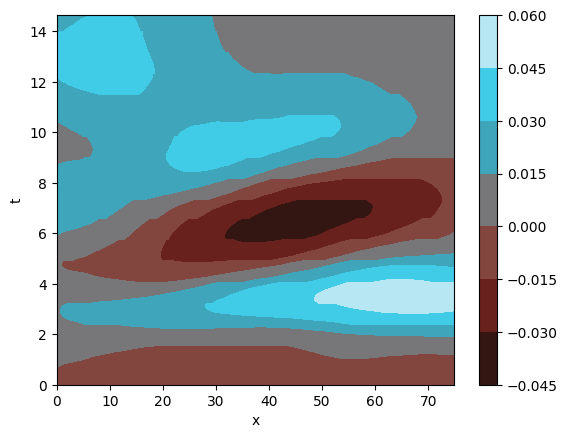

In [3]:
signal_data = pd.read_csv('dataset/signal_matrix_space_data.csv')
time_data = pd.read_csv('dataset/plot_time_label_df.csv')
x = signal_data['nx'].values
x = x - x.min()
t = time_data['frame_in_hours'].values
t = t - t.min()
t,x = np.meshgrid(t,x)
u_data = signal_data.copy()
u_data = u_data.drop(columns=['nx'])
u = np.real(u_data.to_numpy())
data = {}
data['x'] = x
print('Shape of grid x:', data['x'].shape)
data['t'] = t
print('Shape of grid t:', data['t'].shape)
data['u'] = u 
print('Shape of grid u:', data['u'].shape)

fig, ax = plt.subplots()
im = ax.contourf(data['x'], data['t'], data['u'], cmap=cc.cm.CET_CBTL2)
ax.set_xlabel('x')
ax.set_ylabel('t')
fig.colorbar(mappable=im)
plt.show()


In [4]:
X = np.transpose((data['t'].flatten(), data['x'].flatten()))
y = np.real(data['u']).reshape((data['u'].size, 1))
print('X shape, y shape:', X.shape, y.shape)

X shape, y shape: (24640, 2) (24640, 1)


In [5]:
noise_level = 0.025
y_noisy = y + noise_level * np.std(y) * np.random.randn(y[:,0].size, 1)
#coords = torch.from_numpy(np.stack((t.tolist(),x.tolist()), axis=-1)).float()
#X = coords
#y = u

In [6]:
number_of_samples = 20000

idx = np.random.permutation(y.shape[0])
X_train = torch.tensor(X[idx, :][:number_of_samples], dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y_noisy[idx, :][:number_of_samples], dtype=torch.float32)
print(X_train.shape, y_train.shape)

torch.Size([20000, 2]) torch.Size([20000, 1])


In [7]:
len(idx)

24640

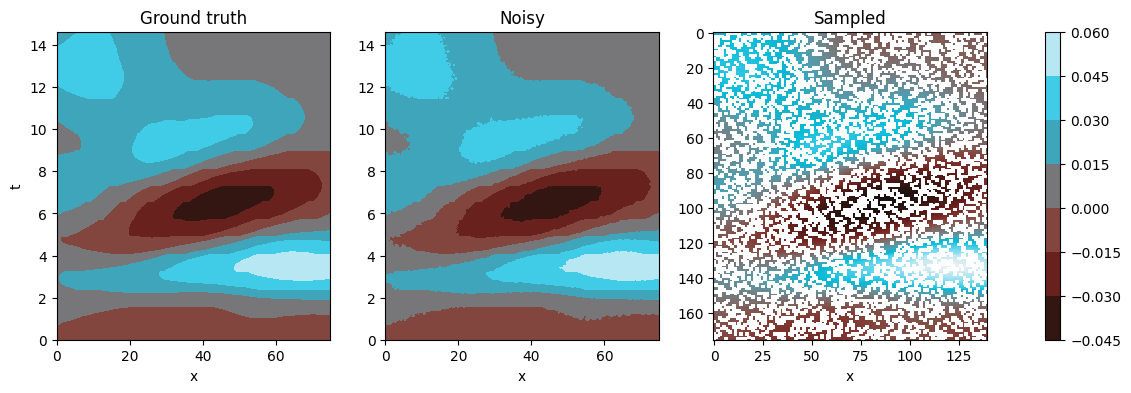

In [8]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))

im0 = axes[0].contourf(data['x'], data['t'], np.real(data['u']), cmap=cc.cm.CET_CBTL2)
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Ground truth')

im1 = axes[1].contourf(data['x'], data['t'], y_noisy.reshape(data['x'].shape), cmap=cc.cm.CET_CBTL2)
axes[1].set_xlabel('x')
axes[1].set_title('Noisy')

sampled = np.array([y_noisy[index, 0] if index in idx[:number_of_samples] else np.nan for index in np.arange(data['x'].size)])
sampled = np.rot90(sampled.reshape(data['x'].shape)) #array needs to be rotated because of imshow

im2 = axes[2].imshow(sampled, aspect='auto', cmap=cc.cm.CET_CBTL2)
axes[2].set_xlabel('x')
axes[2].set_title('Sampled')

fig.colorbar(im1, ax=axes.ravel().tolist())

plt.show()

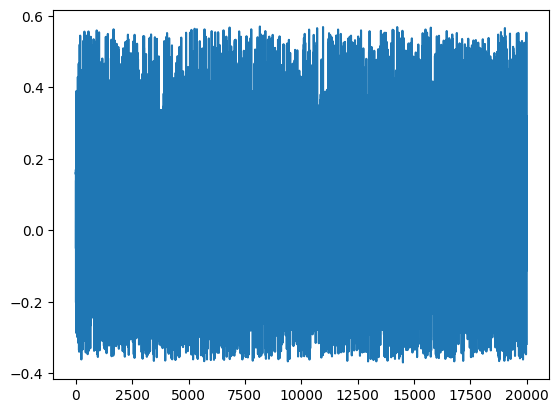

In [11]:
plt.plot(y_train)

Before we send the data into the Dataset format, create a plot to get an idea of the data:

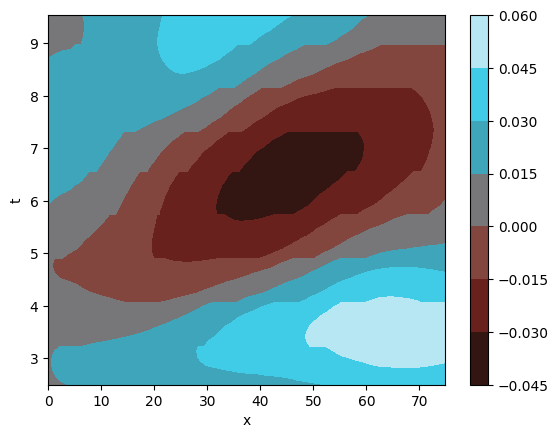

In [14]:
signal_data = pd.read_csv('dataset/signal_matrix_space_data.csv')
x = np.real(signal_data['nx'].values)
x = x - x.min() 
t = time_data['frame_in_hours'].values
t = t - t.min()
t_min = int(30)
t_max = int(115)
u_data = signal_data.copy()
u_data = u_data.drop(columns=['nx'])
u_data = u_data.iloc[:,t_min:t_max]
t = np.real(t[t_min:t_max])
u = np.real(u_data.to_numpy())
t,x = np.meshgrid(t,x)
fig, ax = plt.subplots()
im = ax.contourf(x, t, u, cmap=cc.cm.CET_CBTL2)
ax.set_xlabel('x')
ax.set_ylabel('t')
fig.colorbar(mappable=im)
plt.show()


We can now define a function that loads the data, makes torch tensors out of it and then returns it in a coords, data format. The shape of the samples will be (t,x) for the input and (u) for the dataset. Ensure that any array is not 1D, so an array with a single feature can be the shape (N,1) using reshape(-1,1) in numpy or unsqueeze(-1) in torch.

In [15]:
def load_data():
    coords = torch.from_numpy(np.stack((t.tolist(),x.tolist()), axis=-1)).float()
    data = torch.from_numpy(u).unsqueeze(-1).float()
    return coords, data

In [16]:
dataset = Dataset(
    load_data,
    apply_normalize=True
    subsampler=Subsample_random,
    subsampler_kwargs={"number_of_samples": 20000},
    device=device,
)

Dataset is using device:  cuda


We now also wish to split the data into a train and test split, specifically into loaders, which handle the logic of passing the samples to the model.

In [17]:
train_dataloader, test_dataloader = get_train_test_loader(dataset, train_test_split=0.8)

## Configuring DeepMoD

Configuration of the function approximator: Here the first argument is the number of input and the last argument the number of output layers.


In [18]:
network = NN(2, [30, 30, 30, 30], 1)

Configuration of the library function: We select athe library with a 2D spatial input. Note that that the max differential order has been pre-determined here out of convinience. So, for poly_order 1 the library contains the following 12 terms:
* [$1, u_x, u_{xx}, u_{xxx}, u, u u_{x}, u u_{xx}, u u_{xxx}, u^2, u^2 u_{x}, u^2 u_{xx}, u^2 u_{xxx}$]

In [19]:
library = Library1D(poly_order=2, diff_order=3) 

In [20]:
from deepymod.model.library import library_poly
from deepymod.model.library import library_deriv
library_poly = library_poly(y_train,2)
#library_deriv = library_deriv(load_data_test[0],load_data_test[1],3)

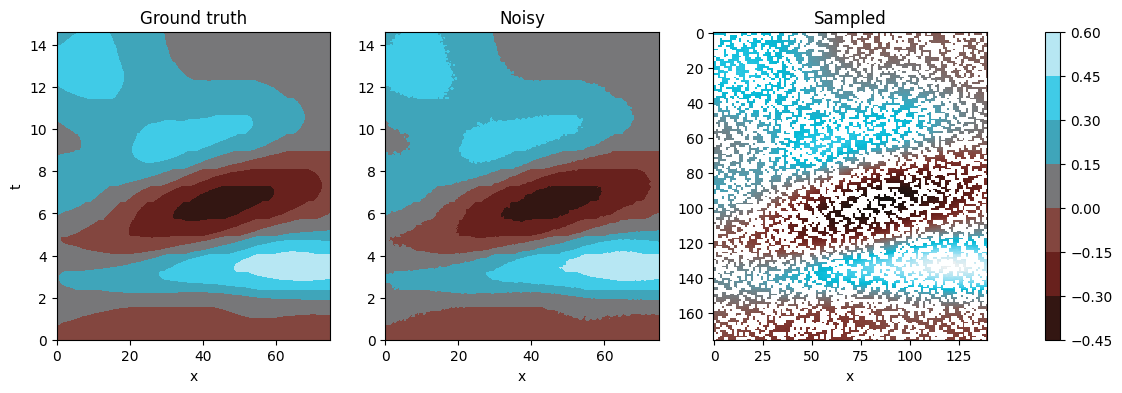

In [21]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))

im0 = axes[0].contourf(data['x'], data['t'], np.real(data['u']), cmap=cc.cm.CET_CBTL2)
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Ground truth')

im1 = axes[1].contourf(data['x'], data['t'], y_noisy.reshape(data['x'].shape), cmap=cc.cm.CET_CBTL2)
axes[1].set_xlabel('x')
axes[1].set_title('Noisy')

sampled = np.array([y_noisy[index, 0] if index in idx[:number_of_samples] else np.nan for index in np.arange(data['x'].size)])
sampled = np.rot90(sampled.reshape(data['x'].shape)) #array needs to be rotated because of imshow

im2 = axes[2].imshow(sampled, aspect='auto', cmap=cc.cm.CET_CBTL2)
axes[2].set_xlabel('x')
axes[2].set_title('Sampled')

fig.colorbar(im1, ax=axes.ravel().tolist())

plt.show()

Configuration of the sparsity estimator and sparsity scheduler used. In this case we use the most basic threshold-based Lasso estimator and a scheduler that asseses the validation loss after a given patience. If that value is smaller than 1e-5, the algorithm is converged. 

In [22]:
estimator = Threshold(0.1) 
sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=10, delta=1e-5)

Configuration of the sparsity estimator

In [23]:
constraint = LeastSquares() 
# Configuration of the sparsity scheduler

In [24]:
model = DeepMoD(network, library, estimator, constraint).to(device)

# Defining optimizer
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=1e-3)

## Run DeepMoD

We can now run DeepMoD using all the options we have set and the training data:

- The directory where the tensorboard file is written (log_dir)
- The ratio of train/test set used (split)
- The maximum number of iterations performed (max_iterations)
- The absolute change in L1 norm considered converged (delta)
- The amount of epochs over which the absolute change in L1 norm is calculated (patience)



In [25]:
train(model, train_dataloader, test_dataloader, optimizer, sparsity_scheduler, log_dir='runs/test_01/', split=0.8, max_iterations=100000)

 23275  MSE: 1.84e-05  Reg: 1.03e-05  L1: 4.79e+00 Algorithm converged. Writing model to disk.


In [26]:
model_sparsity_masks = model.sparsity_masks

In [27]:
model_estimator_coeffs = model.estimator_coeffs()

In [28]:
print(model_estimator_coeffs[0])

[[-0.3999896 ]
 [-1.1933378 ]
 [ 0.        ]
 [-0.44768938]
 [ 0.33793476]
 [ 0.23058282]
 [ 0.        ]
 [ 0.7892465 ]
 [ 0.40743878]
 [-0.43551013]
 [ 0.        ]
 [-0.43651047]]


In [29]:
PDE_string = write_model_expression(model_estimator_coeffs[0], poly_order=2, diff_order=3, latex=False)

all tested functions list:
['1', 'u_{x}', 'u_{xx}', 'u_{xxx}', 'u', 'uu_{x}', 'uu_{xx}', 'uu_{xxx}', 'u^{2}', 'u^{2}u_{x}', 'u^{2}u_{xx}', 'u^{2}u_{xxx}']
--------------------------------------------------------
Inferred equation:
u_t = 0.4000  - 1.1933 u_{x} - 0.4477 u_{xxx} + 0.3379 u + 0.2306 uu_{x} + 0.7892 uu_{xxx} + 0.4074 u^{2} - 0.4355 u^{2}u_{x} - 0.4365 u^{2}u_{xxx}


In [30]:
model_constraint_coeffs = model.constraint_coeffs()

In [31]:
train_dataloader[0]

(tensor([[ 4.5333,  5.9210],
         [ 7.1333, 62.9780],
         [ 2.8667, 13.4568],
         ...,
         [ 9.1667, 21.5309],
         [ 6.5667, 25.8371],
         [ 5.3667, 64.0545]], device='cuda:0'),
 tensor([[-0.0012],
         [-0.0274],
         [ 0.0203],
         ...,
         [ 0.0310],
         [-0.0143],
         [ 0.0056]], device='cuda:0'))

In [139]:
train_dataloader.dataset[2]

(tensor([23.2500, 59.6086], device='cuda:0'),
 tensor([-0.3601], device='cuda:0'))

In [148]:
test_dataloader[0]

(tensor([[20.0167, 61.2234],
         [25.3833, 84.3691],
         [24.9167, 87.0605],
         ...,
         [23.0667, 26.7739],
         [23.9000, 70.3740],
         [21.6833, 76.8333]], device='cuda:0'),
 tensor([[ 0.3923],
         [-0.0847],
         [-0.1488],
         ...,
         [ 0.0907],
         [-0.3366],
         [ 0.2409]], device='cuda:0'))

In [144]:
dataset[0]

(tensor([24.0833, 74.1419], device='cuda:0'),
 tensor([-0.3146], device='cuda:0'))

## Analysing

In [32]:
# right now works with file path, will change to experiment_ID 
df =  load_tensorboard('runs/test_01/')

In [33]:
df.head()

,loss_mse,coeffs_output_0_coeff_0,coeffs_output_0_coeff_1,coeffs_output_0_coeff_10,coeffs_output_0_coeff_11,coeffs_output_0_coeff_2,coeffs_output_0_coeff_3,coeffs_output_0_coeff_4,coeffs_output_0_coeff_5,coeffs_output_0_coeff_6,...,unscaled_coeffs_output_0_coeff_10,unscaled_coeffs_output_0_coeff_11,unscaled_coeffs_output_0_coeff_2,unscaled_coeffs_output_0_coeff_3,unscaled_coeffs_output_0_coeff_4,unscaled_coeffs_output_0_coeff_5,unscaled_coeffs_output_0_coeff_6,unscaled_coeffs_output_0_coeff_7,unscaled_coeffs_output_0_coeff_8,unscaled_coeffs_output_0_coeff_9
0,0.010422,-0.411497,-1.576370,-2.913197,-1.297337,-2.482732,-0.432748,-1.068414,4.331435,5.228761,...,-875.204102,-333.823547,-4.921171,-0.710425,-0.026518,68.978615,129.787338,33.893131,0.341968,-730.254639
25,0.000937,-0.826730,-2.123838,-0.604514,-0.120338,-0.530961,-0.152127,-0.140461,2.811422,0.788056,...,-2872.764160,-445.643799,-1.052502,-0.251751,-0.011179,105.760384,93.461494,47.568489,1.656209,-1470.970947
50,0.001455,-0.099267,-2.080215,4.520232,0.675626,3.508607,-0.005016,-4.734938,2.701793,-7.686687,...,10221.844727,1421.328613,4.464571,-0.005979,-0.151643,99.152206,-445.162292,-25.861595,3.791878,-1374.342773
75,0.001455,-1.838898,-1.251890,4.642962,0.235430,3.645533,0.000000,0.000000,1.371876,-7.936038,...,10492.469727,494.931030,4.637341,0.000000,0.000000,50.326569,-459.348938,0.000000,1.235769,-606.844482
100,0.000919,-0.795694,-0.603268,-0.038831,-0.067295,-0.210259,0.000000,0.000000,0.681819,0.078010,...,-1998.571899,-2213.795166,-0.854452,0.000000,0.000000,151.183304,39.307068,0.000000,3.254117,-4064.923340


In [34]:
df.keys()

Index(['loss_mse', 'coeffs_output_0_coeff_0', 'coeffs_output_0_coeff_1',
       'coeffs_output_0_coeff_10', 'coeffs_output_0_coeff_11',
       'coeffs_output_0_coeff_2', 'coeffs_output_0_coeff_3',
       'coeffs_output_0_coeff_4', 'coeffs_output_0_coeff_5',
       'coeffs_output_0_coeff_6', 'coeffs_output_0_coeff_7',
       'coeffs_output_0_coeff_8', 'coeffs_output_0_coeff_9',
       'estimator_coeffs_output_0_coeff_0',
       'estimator_coeffs_output_0_coeff_1',
       'estimator_coeffs_output_0_coeff_10',
       'estimator_coeffs_output_0_coeff_11',
       'estimator_coeffs_output_0_coeff_2',
       'estimator_coeffs_output_0_coeff_3',
       'estimator_coeffs_output_0_coeff_4',
       'estimator_coeffs_output_0_coeff_5',
       'estimator_coeffs_output_0_coeff_6',
       'estimator_coeffs_output_0_coeff_7',
       'estimator_coeffs_output_0_coeff_8',
       'estimator_coeffs_output_0_coeff_9', 'loss_l1_output_0',
       'loss_reg_output_0', 'unscaled_coeffs_output_0_coeff_0',
      

Text(0.5, 1.0, 'Regression')

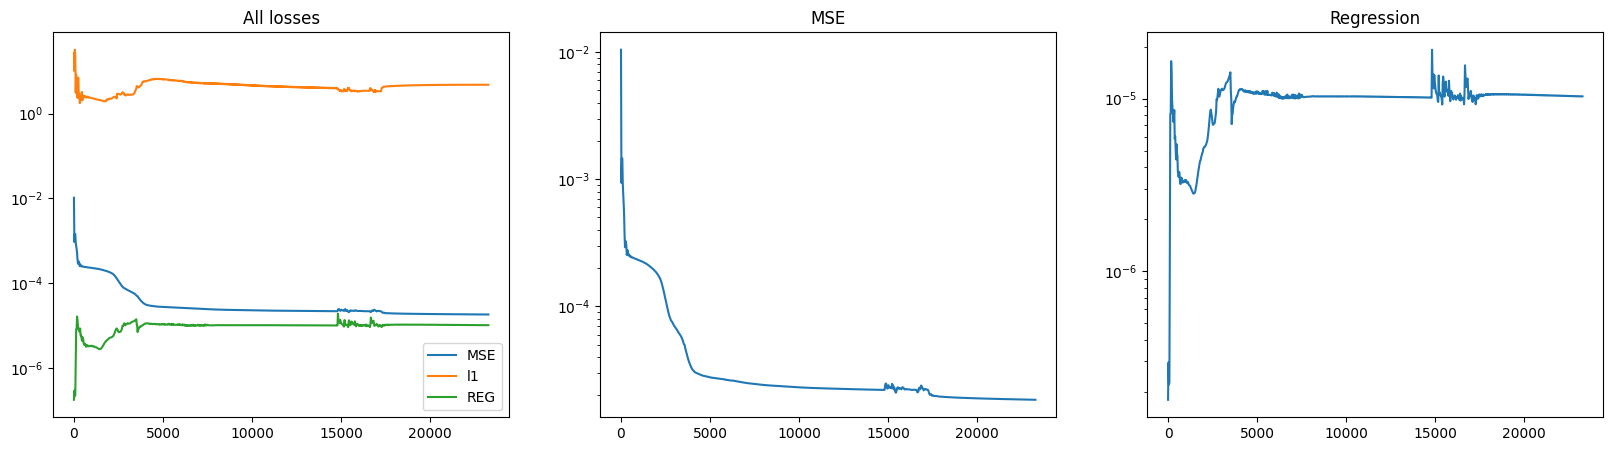

In [35]:
plt.figure(figsize=(20, 5))

plt.subplot(131)
plt.semilogy(df.index, df['loss_mse'], label='MSE')
plt.semilogy(df.index, df['loss_l1_output_0'], label='l1')
plt.semilogy(df.index, df['loss_reg_output_0'], label='REG')
plt.title('All losses')
plt.legend()

plt.subplot(132)
plt.semilogy(df.index, df['loss_mse'], label='MSE')
plt.title('MSE')

plt.subplot(133)
plt.semilogy(df.index, df['loss_reg_output_0'], label='PI')
plt.title('Regression')

In [36]:
coeff_keys = [key for key in df.keys() if key[:5]=='coeff']

Text(0.5, 1.0, 'Coefficients')

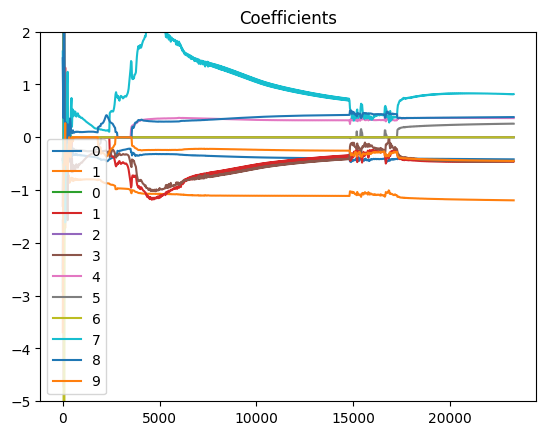

In [37]:
for key in coeff_keys:
    plt.plot(df[key], label=f'{key[-1]}')
plt.legend()
plt.ylim([-5, 2])
plt.title('Coefficients')